In [2]:
!pip install dgl

In [3]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from torch.utils.data import Dataset, DataLoader
import glob
import json
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## Homework 4 - Generative Models of graphs

first lets introduce our dataset, the "flower graphs" dataset


In [4]:
class CustomDataset(Dataset):
    def __init__(self, path):
        

        filelist = glob.glob(path+'/*.json')
        
        self.graphs = []
        for fname in tqdm(filelist):
            with open(fname) as jfile:
                graph = nx.node_link_graph(json.load(jfile))
                g = dgl.DGLGraph()
                g.from_networkx(graph)
                
                self.graphs.append(g)
        
        
    def __len__(self):
       
        return len(self.graphs)


    def __getitem__(self, idx):
        
    
        return self.graphs[idx]

In [5]:
graph_ds = CustomDataset('../../flower_graphs/')

Its a pretty simple dataset, just an "inner circle" plus some short arms,
no node features or edge features

C:\Users\baravni\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


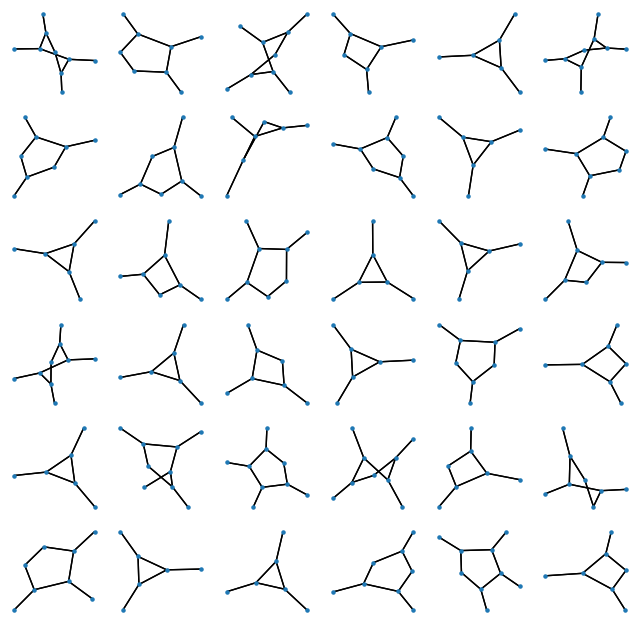

In [6]:
N = 6

fig,ax = plt.subplots(N,N,figsize=(8,8),dpi=100)


idxs = np.random.permutation(np.arange(len(graph_ds)))

for i in range(N):
    for j in range(N):
        idx = idxs[i*N+j]
        nx.draw( graph_ds[idx].to_networkx() ,ax=ax[i][j],node_size=5,arrows=False)

plt.show()

## your goal is to train a network that will generate graphs like these

based on what you saw in the lecture - you need to turn the graph into a sequence of "actions"

the tutorial we are following
https://docs.dgl.ai/en/0.4.x/tutorials/models/3_generative_model/5_dgmg.html

uses a sequence of integers, that represent different things based on where we are in the sequence

the function below converts a graph to a sequence in the right format

In [7]:
def get_decision_sequence(g):
    
    nodes = np.random.permutation( g.nodes() )
    edge_start, edge_end = g.edges()
    elist = np.random.permutation([(es,ee) for es,ee in zip(edge_start, edge_end)])
    added_nodes = []
    added_edges = []
    
    decision_sequence = []

    for node_idx in nodes:
        decision_sequence.append(0)  # Add node
        
        added_nodes.append(node_idx)
        edges_from_node = [e for e in elist if e[0]==node_idx]
        
        for e in edges_from_node:
            
            if e[1] not in added_nodes:
                continue
            elif (e[1],e[0]) in added_edges:
                continue
            decision_sequence.append(0)  # Add edge
            dst = np.where(added_nodes==e[1])[0][0]
            decision_sequence.append(dst)  # Set destination to be previous node.
            added_edges.append((e[0],e[1]))
        decision_sequence.append(1)  # Stop adding edge
    decision_sequence.append(1)  # Stop adding node


    return decision_sequence


In [8]:
get_decision_sequence( graph_ds[5] )

[0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 3,
 1,
 1]

C:\Users\baravni\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


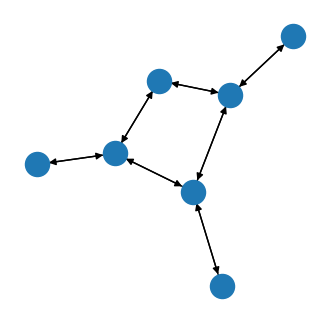

In [9]:
fig,ax = plt.subplots(1,1,figsize=(4,4),dpi=100)
nx.draw( graph_ds[5].to_networkx())
plt.show()

## after you copy-paste all the following code:

In [21]:
def forward_inference(self):
    stop = self.add_node_and_update()
    while (not stop) and (self.g.number_of_nodes() < self.v_max + 1):
        num_trials = 0
        to_add_edge = self.add_edge_or_not()
        while to_add_edge and (num_trials < self.g.number_of_nodes() - 1):
            self.choose_dest_and_update()
            num_trials += 1
            to_add_edge = self.add_edge_or_not()
        stop = self.add_node_and_update()

    return self.g

In [10]:
def forward_train(self, actions):
    """
    - actions: list
        - Contains a_1, ..., a_T described above
    - self.prepare_for_train()
        - Initializes self.action_step to be 0, which will get
          incremented by 1 every time it is called.
        - Initializes objects recording log p(a_t|a_1,...a_{t-1})

    Returns
    -------
    - self.get_log_prob(): log p(a_1, ..., a_T)
    """
    self.prepare_for_train()

    stop = self.add_node_and_update(a=actions[self.action_step])
    while not stop:
        to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
        while to_add_edge:
            self.choose_dest_and_update(a=actions[self.action_step])
            to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
        stop = self.add_node_and_update(a=actions[self.action_step])

    return self.get_log_prob()

In [12]:
import torch.nn as nn
class DGMGSkeleton(nn.Module):
    def __init__(self, v_max):
        """
        Parameters
        ----------
        v_max: int
            Max number of nodes considered
        """
        super(DGMGSkeleton, self).__init__()

        # Graph configuration
        self.v_max = v_max

    def add_node_and_update(self, a=None):
        """Decide if to add a new node.
        If a new node should be added, update the graph."""
        return NotImplementedError

    def add_edge_or_not(self, a=None):
        """Decide if a new edge should be added."""
        return NotImplementedError

    def choose_dest_and_update(self, a=None):
        """Choose destination and connect it to the latest node.
        Add edges for both directions and update the graph."""
        return NotImplementedError

    def forward_train(self, actions):
        """Forward at training time. It records the probability
        of generating a ground truth graph following the actions."""
        return NotImplementedError

    def forward_inference(self):
        """Forward at inference time.
        It generates graphs on the fly."""
        return NotImplementedError

    def forward(self, actions=None):
        # The graph you will work on
        self.g = dgl.DGLGraph()

        # If there are some features for nodes and edges,
        # zero tensors will be set for those of new nodes and edges.
        self.g.set_n_initializer(dgl.frame.zero_initializer)
        self.g.set_e_initializer(dgl.frame.zero_initializer)

        if self.training:
            return self.forward_train(actions=actions)
        else:
            return self.forward_inference()

In [13]:
class GraphEmbed(nn.Module):
    def __init__(self, node_hidden_size):
        super(GraphEmbed, self).__init__()

        # Setting from the paper
        self.graph_hidden_size = 2 * node_hidden_size

        # Embed graphs
        self.node_gating = nn.Sequential(
            nn.Linear(node_hidden_size, 1),
            nn.Sigmoid()
        )
        self.node_to_graph = nn.Linear(node_hidden_size,
                                       self.graph_hidden_size)

    def forward(self, g):
        if g.number_of_nodes() == 0:
            return torch.zeros(1, self.graph_hidden_size)
        else:
            # Node features are stored as hv in ndata.
            hvs = g.ndata['hv']
            return (self.node_gating(hvs) *
                    self.node_to_graph(hvs)).sum(0, keepdim=True)

In [14]:
from functools import partial

class GraphProp(nn.Module):
    def __init__(self, num_prop_rounds, node_hidden_size):
        super(GraphProp, self).__init__()

        self.num_prop_rounds = num_prop_rounds

        # Setting from the paper
        self.node_activation_hidden_size = 2 * node_hidden_size

        message_funcs = []
        node_update_funcs = []
        self.reduce_funcs = []

        for t in range(num_prop_rounds):
            # input being [hv, hu, xuv]
            message_funcs.append(nn.Linear(2 * node_hidden_size + 1,
                                           self.node_activation_hidden_size))

            self.reduce_funcs.append(partial(self.dgmg_reduce, round=t))
            node_update_funcs.append(
                nn.GRUCell(self.node_activation_hidden_size,
                           node_hidden_size))

        self.message_funcs = nn.ModuleList(message_funcs)
        self.node_update_funcs = nn.ModuleList(node_update_funcs)

    def dgmg_msg(self, edges):
        """For an edge u->v, return concat([h_u, x_uv])"""
        return {'m': torch.cat([edges.src['hv'],
                                edges.data['he']],
                               dim=1)}

    def dgmg_reduce(self, nodes, round):
        hv_old = nodes.data['hv']
        m = nodes.mailbox['m']
        message = torch.cat([
            hv_old.unsqueeze(1).expand(-1, m.size(1), -1), m], dim=2)
        node_activation = (self.message_funcs[round](message)).sum(1)

        return {'a': node_activation}

    def forward(self, g):
        if g.number_of_edges() > 0:
            for t in range(self.num_prop_rounds):
                g.update_all(message_func=self.dgmg_msg,
                             reduce_func=self.reduce_funcs[t])
                g.ndata['hv'] = self.node_update_funcs[t](
                     g.ndata['a'], g.ndata['hv'])

In [15]:
import torch.nn.functional as F
from torch.distributions import Bernoulli

def bernoulli_action_log_prob(logit, action):
    """Calculate the log p of an action with respect to a Bernoulli
    distribution. Use logit rather than prob for numerical stability."""
    if action == 0:
        return F.logsigmoid(-logit)
    else:
        return F.logsigmoid(logit)

In [16]:
class AddNode(nn.Module):
    def __init__(self, graph_embed_func, node_hidden_size):
        super(AddNode, self).__init__()

        self.graph_op = {'embed': graph_embed_func}

        self.stop = 1
        self.add_node = nn.Linear(graph_embed_func.graph_hidden_size, 1)

        # If to add a node, initialize its hv
        self.node_type_embed = nn.Embedding(1, node_hidden_size)
        self.initialize_hv = nn.Linear(node_hidden_size + \
                                       graph_embed_func.graph_hidden_size,
                                       node_hidden_size)

        self.init_node_activation = torch.zeros(1, 2 * node_hidden_size)

    def _initialize_node_repr(self, g, node_type, graph_embed):
        """Whenver a node is added, initialize its representation."""
        num_nodes = g.number_of_nodes()
        hv_init = self.initialize_hv(
            torch.cat([
                self.node_type_embed(torch.LongTensor([node_type])),
                graph_embed], dim=1))
        g.nodes[num_nodes - 1].data['hv'] = hv_init
        g.nodes[num_nodes - 1].data['a'] = self.init_node_activation

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, action=None):
        graph_embed = self.graph_op['embed'](g)

        logit = self.add_node(graph_embed)
        prob = torch.sigmoid(logit)

        if not self.training:
            action = Bernoulli(prob).sample().item()
        stop = bool(action == self.stop)

        if not stop:
            g.add_nodes(1)
            self._initialize_node_repr(g, action, graph_embed)

        if self.training:
            sample_log_prob = bernoulli_action_log_prob(logit, action)

            self.log_prob.append(sample_log_prob)

        return stop

In [17]:
class AddEdge(nn.Module):
    def __init__(self, graph_embed_func, node_hidden_size):
        super(AddEdge, self).__init__()

        self.graph_op = {'embed': graph_embed_func}
        self.add_edge = nn.Linear(graph_embed_func.graph_hidden_size + \
                                  node_hidden_size, 1)

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, action=None):
        graph_embed = self.graph_op['embed'](g)
        src_embed = g.nodes[g.number_of_nodes() - 1].data['hv']

        logit = self.add_edge(torch.cat(
            [graph_embed, src_embed], dim=1))
        prob = torch.sigmoid(logit)

        if self.training:
            sample_log_prob = bernoulli_action_log_prob(logit, action)
            self.log_prob.append(sample_log_prob)
        else:
            action = Bernoulli(prob).sample().item()

        to_add_edge = bool(action == 0)
        return to_add_edge

In [18]:
from torch.distributions import Categorical

class ChooseDestAndUpdate(nn.Module):
    def __init__(self, graph_prop_func, node_hidden_size):
        super(ChooseDestAndUpdate, self).__init__()

        self.graph_op = {'prop': graph_prop_func}
        self.choose_dest = nn.Linear(2 * node_hidden_size, 1)

    def _initialize_edge_repr(self, g, src_list, dest_list):
        # For untyped edges, only add 1 to indicate its existence.
        # For multiple edge types, use a one-hot representation
        # or an embedding module.
        edge_repr = torch.ones(len(src_list), 1)
        g.edges[src_list, dest_list].data['he'] = edge_repr

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, dest):
        src = g.number_of_nodes() - 1
        possible_dests = range(src)

        src_embed_expand = g.nodes[src].data['hv'].expand(src, -1)
        possible_dests_embed = g.nodes[possible_dests].data['hv']

        dests_scores = self.choose_dest(
            torch.cat([possible_dests_embed,
                       src_embed_expand], dim=1)).view(1, -1)
        dests_probs = F.softmax(dests_scores, dim=1)

        if not self.training:
            dest = Categorical(dests_probs).sample().item()

        if not g.has_edge_between(src, dest):
            # For undirected graphs, add edges for both directions
            # so that you can perform graph propagation.
            src_list = [src, dest]
            dest_list = [dest, src]

            g.add_edges(src_list, dest_list)
            self._initialize_edge_repr(g, src_list, dest_list)

            self.graph_op['prop'](g)

        if self.training:
            if dests_probs.nelement() > 1:
                self.log_prob.append(
                    F.log_softmax(dests_scores, dim=1)[:, dest: dest + 1])

In [19]:
class DGMG(DGMGSkeleton):
    def __init__(self, v_max, node_hidden_size,
                 num_prop_rounds):
        super(DGMG, self).__init__(v_max)

        # Graph embedding module
        self.graph_embed = GraphEmbed(node_hidden_size)

        # Graph propagation module
        self.graph_prop = GraphProp(num_prop_rounds,
                                    node_hidden_size)

        # Actions
        self.add_node_agent = AddNode(
            self.graph_embed, node_hidden_size)
        self.add_edge_agent = AddEdge(
            self.graph_embed, node_hidden_size)
        self.choose_dest_agent = ChooseDestAndUpdate(
            self.graph_prop, node_hidden_size)

        # Forward functions
        self.forward_train = partial(forward_train, self=self)
        self.forward_inference = partial(forward_inference, self=self)

    @property
    def action_step(self):
        old_step_count = self.step_count
        self.step_count += 1

        return old_step_count

    def prepare_for_train(self):
        self.step_count = 0

        self.add_node_agent.prepare_training()
        self.add_edge_agent.prepare_training()
        self.choose_dest_agent.prepare_training()

    def add_node_and_update(self, a=None):
        """Decide if to add a new node.
        If a new node should be added, update the graph."""

        return self.add_node_agent(self.g, a)

    def add_edge_or_not(self, a=None):
        """Decide if a new edge should be added."""

        return self.add_edge_agent(self.g, a)

    def choose_dest_and_update(self, a=None):
        """Choose destination and connect it to the latest node.
        Add edges for both directions and update the graph."""

        self.choose_dest_agent(self.g, a)

    def get_log_prob(self):
        add_node_log_p = torch.cat(self.add_node_agent.log_prob).sum()
        add_edge_log_p = torch.cat(self.add_edge_agent.log_prob).sum()
        choose_dest_log_p = torch.cat(self.choose_dest_agent.log_prob).sum()
        return add_node_log_p + add_edge_log_p + choose_dest_log_p

## you can now create a model that generates graphs

In [23]:
model = DGMG(v_max=10, node_hidden_size=10, num_prop_rounds=5)

## depending on the model being in training or evaluation mode, it will either generate a model, or evaluate the likelihood given a sequence of steps

In [24]:
model.eval();

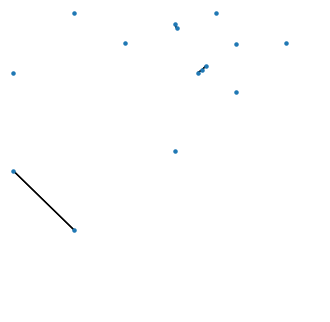

In [25]:
N = 4

fig,ax = plt.subplots(N,N,figsize=(4,4),dpi=100)




for i in range(N):
    for j in range(N):
        
        nx.draw( model().to_networkx() ,ax=ax[i][j],node_size=5,arrows=False)

plt.show()

In [26]:
model.train();

In [27]:
actions = get_decision_sequence(graph_ds[5])

In [28]:
model(actions=actions)

tensor(-26.4271, grad_fn=<AddBackward0>)

If we want to comvert it to porbabilty between 0,1 we'll use the exponent as follows 

In [29]:
model(actions=actions).exp()

tensor(3.3333e-12, grad_fn=<ExpBackward>)

In [30]:
loss = - model(actions=actions)
loss

tensor(26.4271, grad_fn=<NegBackward>)

In [32]:
"""
Learning Deep Generative Models of Graphs
Paper: https://arxiv.org/pdf/1803.03324.pdf
This implementation works with a minibatch of size 1 only for both training and inference.
"""
import torch
from torch.optim import Adam
import numpy as np
import copy

# from model import DGMG

# Setup dataset 
graph_dataset = graph_ds

# Initialize_model
model = DGMG(v_max=10, node_hidden_size=40, num_prop_rounds=10)

# Initialize optimizer
optimizer = Adam(model.parameters(), lr=1e-3)

# Number of epochs
n_epoch = 50


# Training
model.train()
best_loss = np.inf
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(n_epoch):
    epoch_loss = 0
    epoch_prob = 0

    for data in tqdm(graph_dataset):
        optimizer.zero_grad()
        
        action = get_decision_sequence(data)
        
        log_prob = model(actions=actions)
        
        prob = log_prob.detach().exp()
        
        loss = - log_prob

        loss.backward()
        
        epoch_prob += prob.item()


        optimizer.step()
        epoch_loss += loss.detach().item()


    print("epoch {epoch}\nLoss: {loss}\nProbability {prob}\n".format(epoch = epoch, loss = epoch_loss, prob = epoch_prob))

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())


torch.save(best_model_wts, './genaretive_model_graph.pth')



epoch 0
Loss: 1105.9109201431274
Probability 9.005520445507127e-05




epoch 1
Loss: 355.5308210849762
Probability 1.4414479410606873




epoch 2
Loss: 67.34997141361237
Probability 23.94177708029747




epoch 3
Loss: 45.420480251312256
Probability 31.477859914302826




epoch 4
Loss: 43.04250776767731
Probability 32.667572140693665




epoch 5
Loss: 41.23538821935654
Probability 33.60279184579849




epoch 6
Loss: 39.61509257555008
Probability 34.464232325553894




epoch 7
Loss: 38.096860110759735
Probability 35.29149109125137




epoch 8
Loss: 36.650528252124786
Probability 36.09805363416672




epoch 9
Loss: 35.26324701309204
Probability 36.88900941610336




epoch 10
Loss: 33.92891180515289
Probability 37.66612929105759




epoch 11
Loss: 32.644302904605865
Probability 38.42975413799286




epoch 12
Loss: 31.407471388578415
Probability 39.17960464954376




epoch 13
Loss: 30.2170293033123
Probability 39.915146708488464




epoch 14
Loss: 29.071811944246292
Probability 40.635775446891785




epoch 15
Loss: 27.970691859722137
Probability 41.340922594070435




epoch 16
Loss: 26.91255122423172
Probability 42.03007388114929




epoch 17
Loss: 25.89620876312256
Probability 42.70281785726547




epoch 18
Loss: 24.920445203781128
Probability 43.358832120895386




epoch 19
Loss: 23.984004020690918
Probability 43.99788522720337




epoch 20
Loss: 23.085581809282303
Probability 44.61984622478485




epoch 21
Loss: 22.223859310150146
Probability 45.22466051578522




epoch 22
Loss: 21.397508829832077
Probability 45.81234812736511




epoch 23
Loss: 20.60519751906395
Probability 46.38299912214279




epoch 24
Loss: 19.845597743988037
Probability 46.93676370382309




epoch 25
Loss: 19.117421239614487
Probability 47.473826587200165




epoch 26
Loss: 18.419354528188705
Probability 47.99445194005966




epoch 27
Loss: 17.7501699924469
Probability 48.49889653921127




epoch 28
Loss: 17.10863783955574
Probability 48.98747402429581




epoch 29
Loss: 16.49355599284172
Probability 49.460529029369354




epoch 30
Loss: 15.903793007135391
Probability 49.91840189695358




epoch 31
Loss: 15.338227331638336
Probability 50.3614701628685




epoch 32
Loss: 14.795786425471306
Probability 50.790117025375366




epoch 33
Loss: 14.275446847081184
Probability 51.2047278881073




epoch 34
Loss: 13.776220992207527
Probability 51.60569649934769




epoch 35
Loss: 13.297166138887405
Probability 51.993416488170624




epoch 36
Loss: 12.837350577116013
Probability 52.36830526590347




epoch 37
Loss: 12.395935639739037
Probability 52.7307351231575




epoch 38
Loss: 11.972082629799843
Probability 53.081106066703796




epoch 39
Loss: 11.564999759197235
Probability 53.419806480407715




epoch 40
Loss: 11.173927396535873
Probability 53.74722099304199




epoch 41
Loss: 10.798150718212128
Probability 54.063720524311066




epoch 42
Loss: 10.436980322003365
Probability 54.36967432498932




epoch 43
Loss: 10.089773327112198
Probability 54.665432035923004




epoch 44
Loss: 9.755890920758247
Probability 54.95135706663132




epoch 45
Loss: 9.4347675293684
Probability 55.22776687145233




epoch 46
Loss: 9.125812366604805
Probability 55.49501520395279




epoch 47
Loss: 8.828521057963371
Probability 55.75339537858963




epoch 48
Loss: 8.542347505688667
Probability 56.00324904918671




epoch 49
Loss: 8.266826018691063
Probability 56.24486058950424



## submit the trained model source code + saved state_dict 

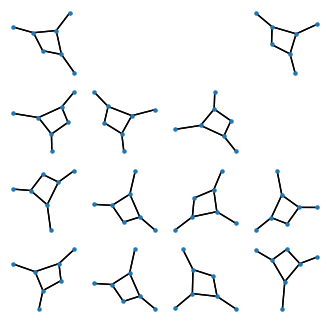

In [33]:
N = 4
model.eval()
fig,ax = plt.subplots(N,N,figsize=(4,4),dpi=100)


for i in range(N):
    for j in range(N):
        
        nx.draw( model().to_networkx() ,ax=ax[i][j],node_size=5,arrows=False)

plt.show()